In [1]:
import os
import glob
import xml.etree.ElementTree as ET

import seaborn as sns
import cv2
import numpy as np
import matplotlib.pyplot as plt

from src.preprocessing.patching import Patching, Stitching, Annotations, Slide
from src.utilities.utils import mask2rgb

In [2]:
STEP=512
MAG_LEVEL=2
SIZE=(1500,1500)

WSI_MASK_PATH='/Users/gregoryverghese/Projects/lymphnode-keras/lymphnode-keras/output/wsi_mask'
GERMINAL_PATH='/Users/gregoryverghese/Projects/lymphnode-keras/lymphnode-keras/output/germinal'
SINUS_PATH='/Users/gregoryverghese/Projects/lymphnode-keras/lymphnode-keras/output/sinus'

wsi_paths='/Users/gregoryverghese/Projects/lymphnode-keras/lymphnode-keras/data/wsi'
annotations_paths='/Users/gregoryverghese/Projects/lymphnode-keras/lymphnode-keras/data/annotations'

In [3]:
wsi_paths=glob.glob(os.path.join(wsi_paths,'*'))
annotations_paths=glob.glob(os.path.join(annotations_paths,'*'))

In [4]:
#### Need to make sure we are creating classes based on integers
#### Need to look into encoding
#### problem with class + 1 in rgb2mask
#### 

14.90610 C L2.11
['/Users/gregoryverghese/Projects/lymphnode-keras/lymphnode-keras/data/annotations/14.90610 C L2.11.json']
keys {'sinus': 0, 'GC': 1}
dict_keys([1, 0])
U_90333_8_B_LOW_8_L1
['/Users/gregoryverghese/Projects/lymphnode-keras/lymphnode-keras/data/annotations/U_90333_8_B_LOW_8_L1.json', '/Users/gregoryverghese/Projects/lymphnode-keras/lymphnode-keras/data/annotations/U_90333_8_B_LOW_8_L1.xml']
keys {'sinus': 0, 'GERMINAL CENTRE': 1, 'SINUS': 2, 'GC': 3}
dict_keys([3, 0, 1, 2])


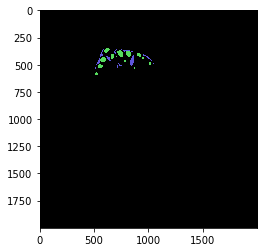

In [5]:
for p in wsi_paths:
    name=os.path.basename(p)[:-5]
    print(name)
    ann_path=[a for a in annotations_paths if name in a]
    print(ann_path)
    ann_obj=Annotations(ann_path,source=['imagej','qupath'])
    ann_obj.generate_annotations()
    ann_obj.filter_labels(['GC', 'sinus', 'GERMINAL CENTRE', 'SINUS'])
    ann_obj.encode_keys()
    
    
    annotations=ann_obj._annotations
    print(annotations.keys())
    wsi=Slide(p,annotations=annotations)
    wsi.get_border()
    mask=wsi.slide_mask
    plt.imshow(mask)
    cv2.imwrite(os.path.join(WSI_MASK_PATH,name+'.png'),mask)
    
    ################Get germinal centres#####################
    
    ann_obj=Annotations(ann_path,source=['imagej','qupath'])
    ann_obj.generate_annotations()
    ann_obj.filter_labels(['GC', 'GERMINAL CENTRE'])
    annotations=ann_obj._annotations
    new_annotations=annotations
    if len(ann_path)==2:
        new_annotations={}
        new_annotations['germinals']=annotations['GC']+annotations['GERMINAL CENTRE']
    new_annotations={i: v for i, v in enumerate(new_annotations.values())}
    wsi_germs=Slide(p,annotations=new_annotations,draw_border=True)
    wsi_germs.get_border()
    patches=Patching(wsi_germs,mag_level=MAG_LEVEL,size=SIZE)
    num=patches.generate_patches(STEP, mask_flag=True)
    print('num patches: {}'.format(num))
    patches.save(GERMINAL_PATH,mask_flag=True)
    
    #################=Get sinuses###############
    
    ann_obj=Annotations(ann_path,source=['imagej','qupath'])
    ann_obj.generate_annotations()
    ann_obj.filter_labels(['sinus', 'SINUS'])
    annotations=ann_obj._annotations
    new_annotations=annotations
    if len(ann_path)==2:
        new_annotations={}
        new_annotations['sinus']=annotations['sinus']+annotations['SINUS']
    new_annotations={i: v for i, v in enumerate(new_annotations.values())}
    wsi_sinus=Slide(p,annotations=new_annotations,draw_border=True)
    print(new_annotations)
    wsi_sinus.get_border()
    print("border",wsi_sinus._border)
    patches=Patching(wsi_sinus,mag_level=MAG_LEVEL,size=SIZE)
    num=patches.generate_patches(STEP, mask_flag=True)
    print('num patches: {}'.format(num))
    patches.save(SINUS_PATH,mask_flag=True)
    